In [1]:
from nilearn.datasets import MNI152_FILE_PATH
import pandas as pd
from nilearn import image, glm, plotting, input_data, datasets

import numpy as np


import nibabel as nib


import time
import os
import statsmodels.api as sm
#from nilearn.datasets import load_mni152_gm_template
import pdb

import matplotlib.pyplot as plt


/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/home/vayzenbe/.conda/envs/brainiak/lib/python3.7/site-packages/nilearn/glm/__init__.py:56: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  'It may change in any future release of Nilearn.', FutureWarning)


In [84]:
study ='docnet'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
out_dir = f'{study_dir}/derivatives/fc'
results_dir = '/user_data/vayzenbe/GitHub_Repos/docnet/results'
exp = 'catmvpa'

subj_list = [2001,2002,2003,2004, 2005, 2007, 2008, 2012, 2013, 2014, 2015, 2016]


ventral_rois = ['LO_toolloc', 'PFS_toolloc']
dorsal_rois = ['PPC_spaceloc',  'PPC_toolloc','PPC_distloc', 'APC_spaceloc',  'APC_toolloc','APC_distloc']

brain_mask = image.load_img('/user_data/vayzenbe/GitHub_Repos/fmri/roiParcels/mruczek_parcels/binary/all_visual_areas.nii.gz')
affine = brain_mask.affine
vols = 331

alpha = .05

In [85]:
def dist_normalize(brain_mask, seed_mask, stat):
    
    #create empty brain
    dist_img = np.zeros(stat.shape)
    
    #extract center of seed
    seed_coords = np.mean(np.array(list(np.where(seed_mask == 1))), axis =1)
    seed_coords = seed_coords.reshape((1,3))

    #extract all coords of brain mask
    brain_coords = np.transpose(np.array(list(np.where(brain_mask == 1))))
    brain_df = pd.DataFrame(brain_coords, columns = ['x','y','z'])

    #Calculate dist of all mask coords from seed
    dists = np.linalg.norm(brain_coords-seed_coords, axis=-1)
    dists = dists.reshape((dists.shape[0], 1))
    brain_df['dist'] = dists
    #min/max normalize coords
    brain_df['dist_norm'] = (brain_df['dist'] - brain_df['dist'].min()) / (brain_df['dist'].max() - brain_df['dist'].min())

    #extract stat vals from brain image
    stat_vals = stat[tuple(np.transpose(brain_coords[:,0:3].astype(int)))]
    stat_vals = stat_vals.reshape((stat_vals.shape[0],1))
    brain_df['zstat'] =stat_vals

    #create distance normalized image
    brain_df['zstat_distnorm'] = brain_df['zstat'] * brain_df['zstat']

    dist_img[tuple(np.transpose(brain_coords[:,0:3].astype(int)))] = brain_df['zstat_distnorm']

    return dist_img

In [108]:
"""
run 2nd level model on each subjects MVPD analysis
"""
second_level_model = glm.second_level.SecondLevelModel(smoothing_fwhm=4)
alpha = .05
rois = ["rPPC_spaceloc", "rAPC_spaceloc", "lAPC_distloc"]
mask_img = image.get_data(brain_mask)

for rr in rois:
    fc_img = []
    for ss in subj_list:
        sub_dir = f'{study_dir}/sub-{study}{ss}/ses-02/'
        roi_dir = f'{sub_dir}/derivatives/rois'
        seed_img = image.get_data(image.load_img(f'{roi_dir}/spheres/{rr}_sphere.nii.gz'))

        #if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
        curr_img = image.get_data(image.load_img(f'{out_dir}/{study}{ss}_{rr}_mvpd.nii.gz'))
        

        
        curr_img[mask_img[:, :, :] == 1] = np.arctanh(curr_img[mask_img[:, :, :] == 1])
        norm_img = nib.Nifti1Image(curr_img, affine)  # create the volume image
        nib.save(norm_img, f'{out_dir}/{study}{ss}_{rr}_mvpd_fishz.nii.gz')

        curr_img = dist_normalize(mask_img, seed_img,curr_img)
        norm_img = nib.Nifti1Image(curr_img, affine)  # create the volume image
        nib.save(norm_img, f'{out_dir}/{study}{ss}_{rr}_mvpd_distnorm.nii.gz')

        
        curr_img[mask_img[:, :, :] == 1] = (curr_img[mask_img[:, :, :] == 1] - curr_img[mask_img[:, :, :] == 1].mean())/np.std(curr_img[mask_img[:, :, :] == 1])
        #curr_img = image.math_img("np.arctanh(img)", img=curr_img)
        #curr_img = image.math_img("(img - np.mean(img))/np.std(img)", img=curr_img)
        
        fc_img.append(norm_img)


    design_matrix = pd.DataFrame([1] * len(fc_img),
                            columns=['intercept'])
    final_img= second_level_model.fit(fc_img, design_matrix= design_matrix)
    z_map = final_img.compute_contrast(output_type='z_score')

    thresh_img = glm.threshold_stats_img(z_map,alpha=alpha,height_control='fdr', mask_img =brain_mask)
    #thresh_img = image.threshold_img(final_img, thresh_val[1])

    nib.save(z_map, f'{out_dir}/{study}_group_{rr}_mvpd.nii.gz')



lLO_toolloc


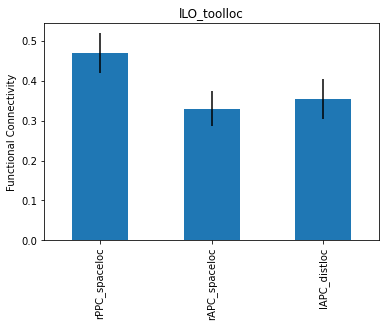

rLO_toolloc


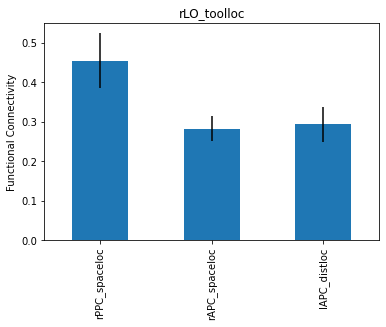

In [109]:
"""
extract avg signal in LO  and PFS

"""
ventral_rois = ['LO_toolloc']
rois = ["rPPC_spaceloc",'rAPC_spaceloc', "lAPC_distloc"]

#For each ventral ROI
for lr in ['l', 'r']:
    for vr in ventral_rois:    
        summary_df = pd.DataFrame(columns = ['sub'] + [rr for rr in rois])
        #summary_df = pd.DataFrame(columns = ['sub'] + ['r' + rr for rr in rois])
        ventral = f'{lr}{vr}'
        
        print(ventral)
        for ss in subj_list:
            
            sub_dir = f'{study_dir}/sub-{study}{ss}/ses-02/'
            roi_dir = f'{sub_dir}/derivatives/rois'
            
        
            ventral_mask = image.load_img(f'{roi_dir}/spheres/{ventral}_sphere.nii.gz')
            ventral_mask = input_data.NiftiMasker(ventral_mask)
                        
            roi_mean = []
            roi_mean.append(ss)
            #For each dorsal ROI
        
            for rr in rois:
                
                roi = rr
                #if os.path.exists(f'{roi_dir}/{roi}_peak.nii.gz'):
                fc_img = image.load_img(f'{out_dir}/{study}{ss}_{rr}_mvpd_distnorm.nii.gz')
                
                #ppi_img  = image.smooth_img(ppi_img, 6)
                acts = ventral_mask.fit_transform(fc_img)

                roi_mean.append(acts.mean())

            summary_df = summary_df.append(pd.Series(roi_mean, index = summary_df.columns), ignore_index = True)

        summary_df.to_csv(f'{results_dir}/{ventral}_mvpd.csv', index=False)
        summary_df.iloc[:, 1:].mean().plot(kind = 'bar', title = ventral, ylabel = 'Functional Connectivity',
        yerr=[summary_df.iloc[:,1:].sem().to_list(), summary_df.iloc[:,1:].sem().to_list()])
        plt.pause(0.0001)

In [ ]:
seed_rois = ['rPPC_spaceloc','lAPC_distloc']

for sr in seed_rois:
    for ss in subj_list:
        print(ss, sr)
        sub_dir = f'{study_dir}/sub-{study}{ss}/ses-02/'
        cov_dir = f'{sub_dir}/covs'
        roi_dir = f'{sub_dir}/derivatives/rois'
        roi = image.load_img(f'{roi_dir}/spheres/{sr}_sphere.nii.gz')

        stat = image.load_img(f'{out_dir}/{study}{ss}_{rr}_mvpd.nii.gz')

        plotting.plot_roi(roi, threshold = .5)
        plt.pause(0.001)



lLO_toolloc


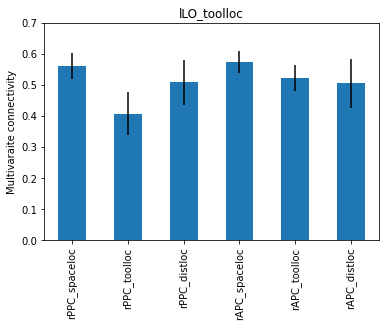

lPFS_toolloc


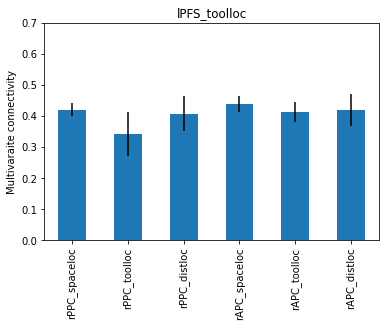

rLO_toolloc


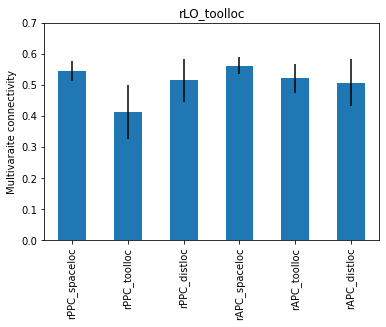

rPFS_toolloc


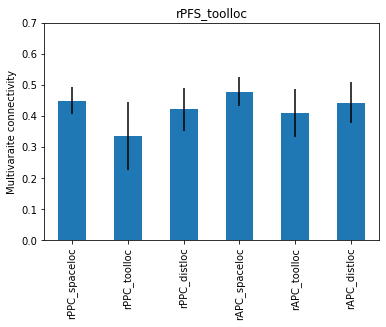

In [74]:
"""
analyze in ventral regions
"""

for lr in ['l','r']:
    for vr in ventral_rois:
        vroi = f'{lr}{vr}'
        roi_summary = pd.DataFrame(columns = ['sub'] + ['r' + dr for dr in dorsal_rois])
        for ss in subj_list:
            curr_df = pd.read_csv(f'{out_dir}/{study}{ss}_mvc.csv')
            curr_df = curr_df[curr_df['ventral_roi'] == vroi]
            
            roi_data = [ss]
            for lr2 in ['r']:
                for dr in dorsal_rois:
                    droi = f'{lr2}{dr}'
                    try:
                        roi_data.append(curr_df['mvc'][curr_df['dorsal_roi'] == droi].to_numpy()[0])
                    except:
                        roi_data.append(np.nan)

            
            roi_summary = roi_summary.append(pd.Series(roi_data, index = roi_summary.columns), ignore_index=True)
    
        print(vroi)
        roi_summary.to_csv(f'{results_dir}/{vroi}_mvc_summary.csv', index = False)
        roi_summary.iloc[:,1:].mean().plot(kind = 'bar', title = vroi, ylim = [0, .7], ylabel = 'Multivaraite connectivity',
        yerr=[roi_summary.iloc[:,1:].sem().to_list(), roi_summary.iloc[:,1:].sem().to_list()])
        plt.pause(0.0001)


    

